In [20]:
import scanpy as sc
import pandas as pd
import numpy as np
import squidpy as sp
import math
import warnings
import matplotlib.pyplot as plt


from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier


warnings.filterwarnings('ignore')

In [2]:
def read_file(filename):
    adata = sc.read_h5ad(filename)

    return adata

In [3]:
def preprocess_file(adata):
    #get rid of cells with fewer than 200 genes
    sc.pp.filter_cells(adata, min_genes=200)
    #get rid of genes that are found in fewer than 3 cells
    sc.pp.filter_genes(adata, min_cells=3)
    #get rid of cells whose annotation is unknown
    adata = adata[~adata.obs.annotation.isin(['Unknown'])]
    #data normalization
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    return adata

In [4]:
def select_best_features(adata, k_best_value):
    feature_selector = SelectKBest(k = k_best_value)
    y = adata.obs.annotation
    adata.feature_selected = np.zeros((len(adata.obs.annotation),2))
    adata.feature_selected[:,0]= adata.obsm['spatial'][:,0]
    adata.feature_selected[:,1]= adata.obsm['spatial'][:,1]
    
    feature_selected = feature_selector.fit_transform(adata.X,y)
    adata.feature_selected = np.hstack((adata.feature_selected, feature_selected.toarray() ))
    scaler = StandardScaler()
    adata.feature_selected = scaler.fit_transform(adata.feature_selected,y)

    return adata 

In [5]:
def get_all_predictions(X, y, clf, k):
    strtfdKFold = StratifiedKFold(n_splits=k)
    kfold = strtfdKFold.split(X, y)
    predictions = None

    for fold_index, (train, test) in enumerate(kfold):
        clf.fit(X[train], y[train])
        if predictions is None:
            predictions = clf.predict(X)
        else:
            predictions = np.vstack((predictions, clf.predict(X)))
    return predictions

In [6]:
def refine_annotations(predictions, y, l):
    new_annotations = y.copy()
    count_refined = 0
    for col_index in range(predictions.shape[1]):
        column = predictions[:,col_index].T
        count_different = len(column[column != y[col_index]])
        if count_different <= l:
            continue
        count_different_by_class = dict()
        for label in column[column != y[col_index]]:
            if label in count_different_by_class:
                count_different_by_class[label] += 1
            else:
                count_different_by_class[label] = 1
        label_with_max = max(count_different_by_class, key=lambda key: count_different_by_class[key])
        max_value = count_different_by_class[label_with_max]
        if max_value > l:
            #print(col_index, y[col_index], label_with_max)
            new_annotations[col_index] = label_with_max
            count_refined += 1
    return new_annotations, count_refined

In [23]:
filename_mouse_embryo = '../Downloads/E9.5_E1S1.MOSTA.h5ad'
filename_mouse_brain = '../Downloads/Mouse_brain_cell_bin.h5ad'

k_best_features = [10, 20, 50, 100]
k_number_of_folds = [3, 5, 7, 10]
l_value_percentage = 0.5
sgd = SGDClassifier()

In [15]:
adata = read_file(filename_mouse_embryo)
adata = preprocess_file(adata)

In [16]:
results_table = []
for number_of_features in k_best_features:
    select_best_features(adata, number_of_features)
    for number_of_folds in k_number_of_folds:
        print(number_of_features, number_of_folds)
        predictions = get_all_predictions(adata.feature_selected, adata.obs.annotation, sgd, number_of_folds)
        for l in range(math.ceil(l_value_percentage * number_of_folds), number_of_folds):
            new_annotations, count_refined = refine_annotations(predictions, adata.obs.annotation, l)
            adata.obs['new_ann'] = new_annotations;
            adata.uns['new_ann_colors'] = adata.uns['annotation_colors']
            #sp.pl.spatial_scatter(adata,shape = None, color=["new_ann","annotation"])
            results_table.append([number_of_features, number_of_folds, l, count_refined])
print(results_table)
            
            
            
            

10 3
10 5
10 7
10 10
20 3
20 5
20 7
20 10
50 3
50 5
50 7
50 10
100 3
100 5
100 7
100 10
[[10, 3, 2, 604], [10, 5, 2, 1551], [10, 5, 3, 1049], [10, 5, 4, 582], [10, 7, 3, 1635], [10, 7, 4, 1284], [10, 7, 5, 957], [10, 7, 6, 656], [10, 10, 4, 1721], [10, 10, 5, 1500], [10, 10, 6, 1266], [10, 10, 7, 1053], [10, 10, 8, 804], [10, 10, 9, 561], [20, 3, 2, 623], [20, 5, 2, 1446], [20, 5, 3, 1011], [20, 5, 4, 616], [20, 7, 3, 1599], [20, 7, 4, 1240], [20, 7, 5, 928], [20, 7, 6, 613], [20, 10, 4, 1640], [20, 10, 5, 1369], [20, 10, 6, 1176], [20, 10, 7, 964], [20, 10, 8, 762], [20, 10, 9, 532], [50, 3, 2, 331], [50, 5, 2, 1028], [50, 5, 3, 635], [50, 5, 4, 361], [50, 7, 3, 1095], [50, 7, 4, 844], [50, 7, 5, 638], [50, 7, 6, 410], [50, 10, 4, 1192], [50, 10, 5, 1001], [50, 10, 6, 826], [50, 10, 7, 691], [50, 10, 8, 541], [50, 10, 9, 365], [100, 3, 2, 224], [100, 5, 2, 790], [100, 5, 3, 509], [100, 5, 4, 297], [100, 7, 3, 818], [100, 7, 4, 625], [100, 7, 5, 436], [100, 7, 6, 276], [100, 10, 4, 891

[[  10    3    2  604]
 [  10    5    2 1551]
 [  10    5    3 1049]
 [  10    5    4  582]
 [  10    7    3 1635]
 [  10    7    4 1284]
 [  10    7    5  957]
 [  10    7    6  656]
 [  10   10    4 1721]
 [  10   10    5 1500]
 [  10   10    6 1266]
 [  10   10    7 1053]
 [  10   10    8  804]
 [  10   10    9  561]]
[[  20    3    2  623]
 [  20    5    2 1446]
 [  20    5    3 1011]
 [  20    5    4  616]
 [  20    7    3 1599]
 [  20    7    4 1240]
 [  20    7    5  928]
 [  20    7    6  613]
 [  20   10    4 1640]
 [  20   10    5 1369]
 [  20   10    6 1176]
 [  20   10    7  964]
 [  20   10    8  762]
 [  20   10    9  532]]
[[  50    3    2  331]
 [  50    5    2 1028]
 [  50    5    3  635]
 [  50    5    4  361]
 [  50    7    3 1095]
 [  50    7    4  844]
 [  50    7    5  638]
 [  50    7    6  410]
 [  50   10    4 1192]
 [  50   10    5 1001]
 [  50   10    6  826]
 [  50   10    7  691]
 [  50   10    8  541]
 [  50   10    9  365]]
[[100   3   2 224]
 [100   5   

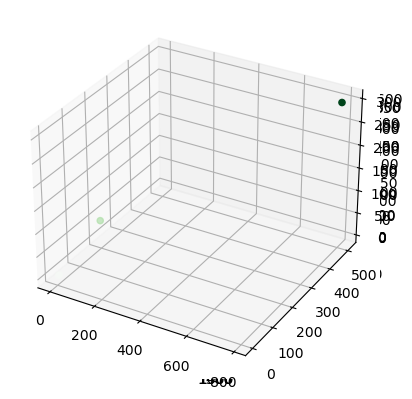

In [26]:
for number_of_features in k_best_features:
    results_table_new = None
    for result in results_table:
        if result[0] == number_of_features:
            if results_table_new is None:
                results_table_new = result
            else:
                results_table_new = np.vstack((results_table_new, result))
    print(results_table_new)
    ax = plt.axes(projection='3d')
    zdata = results_table_new[:, 3]
    xdata = results_table_new[1]
    ydata = results_table_new[2]
    ax.scatter3D(xdata, ydata, zdata, c=zdata, cmap='Greens');